In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

In [7]:
# Paths to your dataset
train_path = '/content/drive/MyDrive/Data/train'
valid_path = '/content/drive/MyDrive/Data/valid'
test_path = '/content/drive/MyDrive/Data/test'

In [8]:
# Constants
IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 32
# CHANNELS = 1

In [9]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=True
)

valid_generator = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=True
)

test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=True
)

# Convert grayscale images to RGB using TensorFlow operations
def convert_to_rgb(images):
    return tf.image.grayscale_to_rgb(images)

# Store class names
class_names = train_generator.class_names

Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


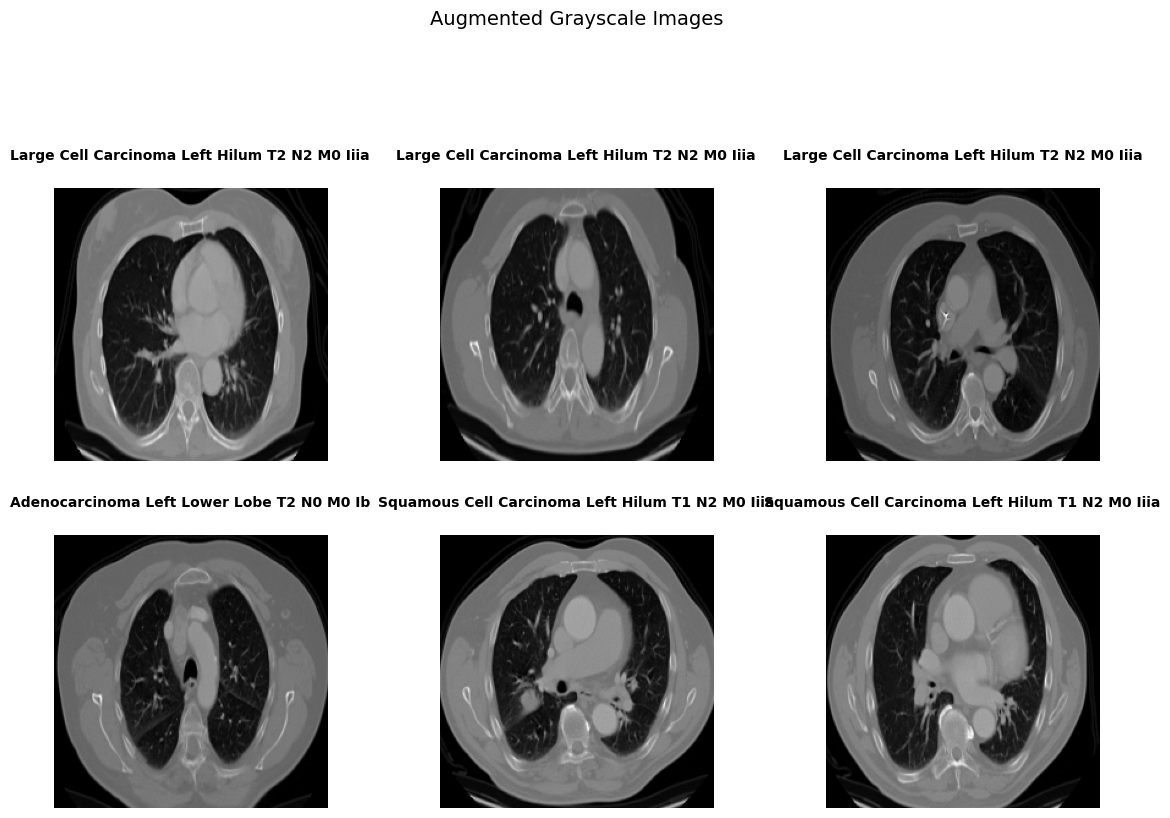

In [10]:
# Function to format class names with spacing
def format_class_name(class_name):
    return class_name.replace(".", " ").replace("_", " ").title()

# Display Augmented Images with Class Names
def display_augmented_images(generator, num_images=6):
    for images, labels in generator.take(1):
        plt.figure(figsize=(12, 8))
        for i in range(num_images):
            plt.subplot(2, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.axis('off')
            class_label = format_class_name(class_names[labels[i].numpy()])
            plt.title(class_label, pad=20, fontsize=10, fontweight="bold", wrap=True)
        plt.suptitle('Augmented Grayscale Images', fontsize=14, y=1.05)
        plt.tight_layout(pad=3.0)
        plt.show()

# Display augmented images
display_augmented_images(train_generator)


In [11]:
# Build the ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(N_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpointer = ModelCheckpoint('chestmodel.keras', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    train_generator.map(lambda x, y: (convert_to_rgb(x), y)),  # Convert to RGB using TensorFlow
    epochs=50,
    validation_data=valid_generator.map(lambda x, y: (convert_to_rgb(x), y)),  # Convert to RGB using TensorFlow
    callbacks=[checkpointer, early_stopping]
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3960 - loss: 1.9319
Epoch 1: val_loss improved from inf to 1.02680, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 153s 7s/step - accuracy: 0.4000 - loss: 1.9076 - val_accuracy: 0.4583 - val_loss: 1.0268
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5875 - loss: 0.9232
Epoch 2: val_loss improved from 1.02680 to 0.93825, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.5890 - loss: 0.9200 - val_accuracy: 0.5694 - val_loss: 0.9383
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6587 - loss: 0.7485
Epoch 3: val_loss improved from 0.93825 to 0.77107, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.6591 - loss: 0.7491 - val_accuracy: 0.6528 - val_loss: 0.7711
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6882 - loss: 0.7427
Epoch 4: val_loss did not improve from 0.77107
20/20 ━━━━━━━━━━━━━━━━

In [12]:
# Evaluate the model
result = model.evaluate(test_generator.map(lambda x, y: (convert_to_rgb(x), y)))  # Convert to RGB using TensorFlow
print(f'Test Loss: {result[0]}, Test Accuracy: {result[1]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - accuracy: 0.7878 - loss: 0.5882
Test Loss: 0.6083963513374329, Test Accuracy: 0.7682539820671082


In [13]:
# Predictions
# Get true labels from the test generator
y_true = []
for _, labels in test_generator:
    y_true.extend(labels.numpy())  # Convert labels to numpy and extend the list
y_true = np.array(y_true)  # Convert the list to a numpy array

# Make predictions
y_pred = model.predict(test_generator.map(lambda x, y: (convert_to_rgb(x), y)))  # Convert to RGB using TensorFlow
y_pred_classes = np.argmax(y_pred, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step


Classification Report:
                         precision    recall  f1-score   support

         Adenocarcinoma       0.38      0.33      0.35       120
Squamous Cell Carcinoma       0.20      0.16      0.17        51
   Large Cell Carcinoma       0.15      0.15      0.15        54
 Small Cell Lung Cancer       0.30      0.39      0.34        90

               accuracy                           0.29       315
              macro avg       0.26      0.25      0.25       315
           weighted avg       0.29      0.29      0.28       315



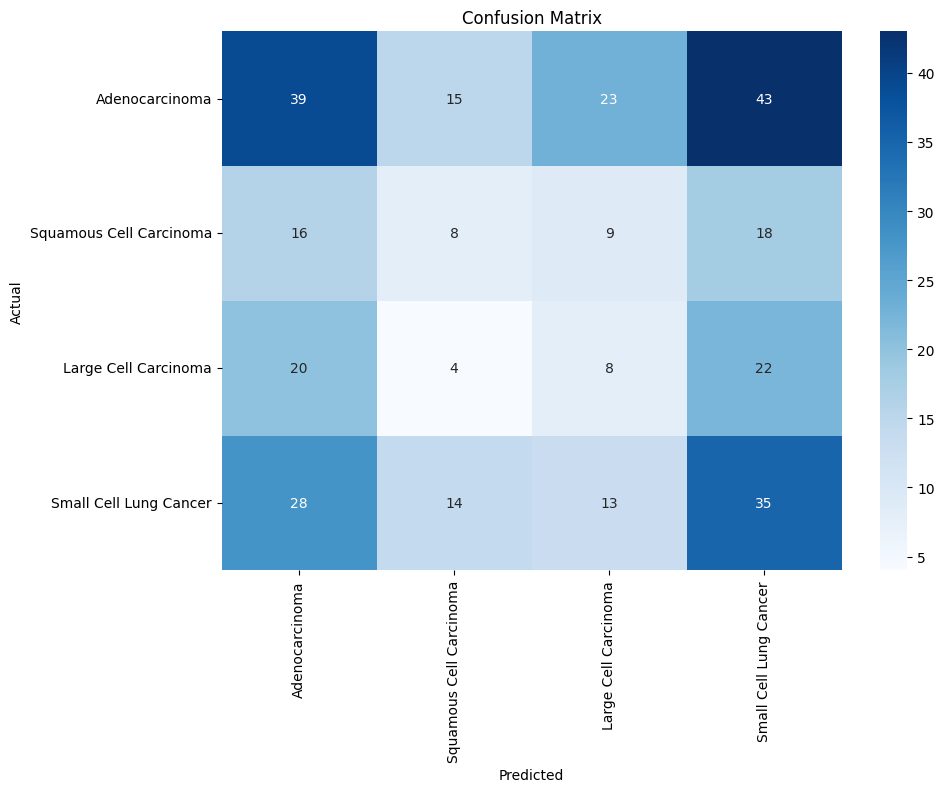

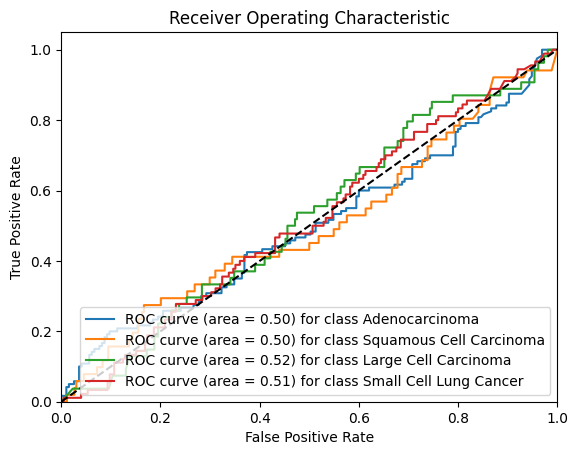

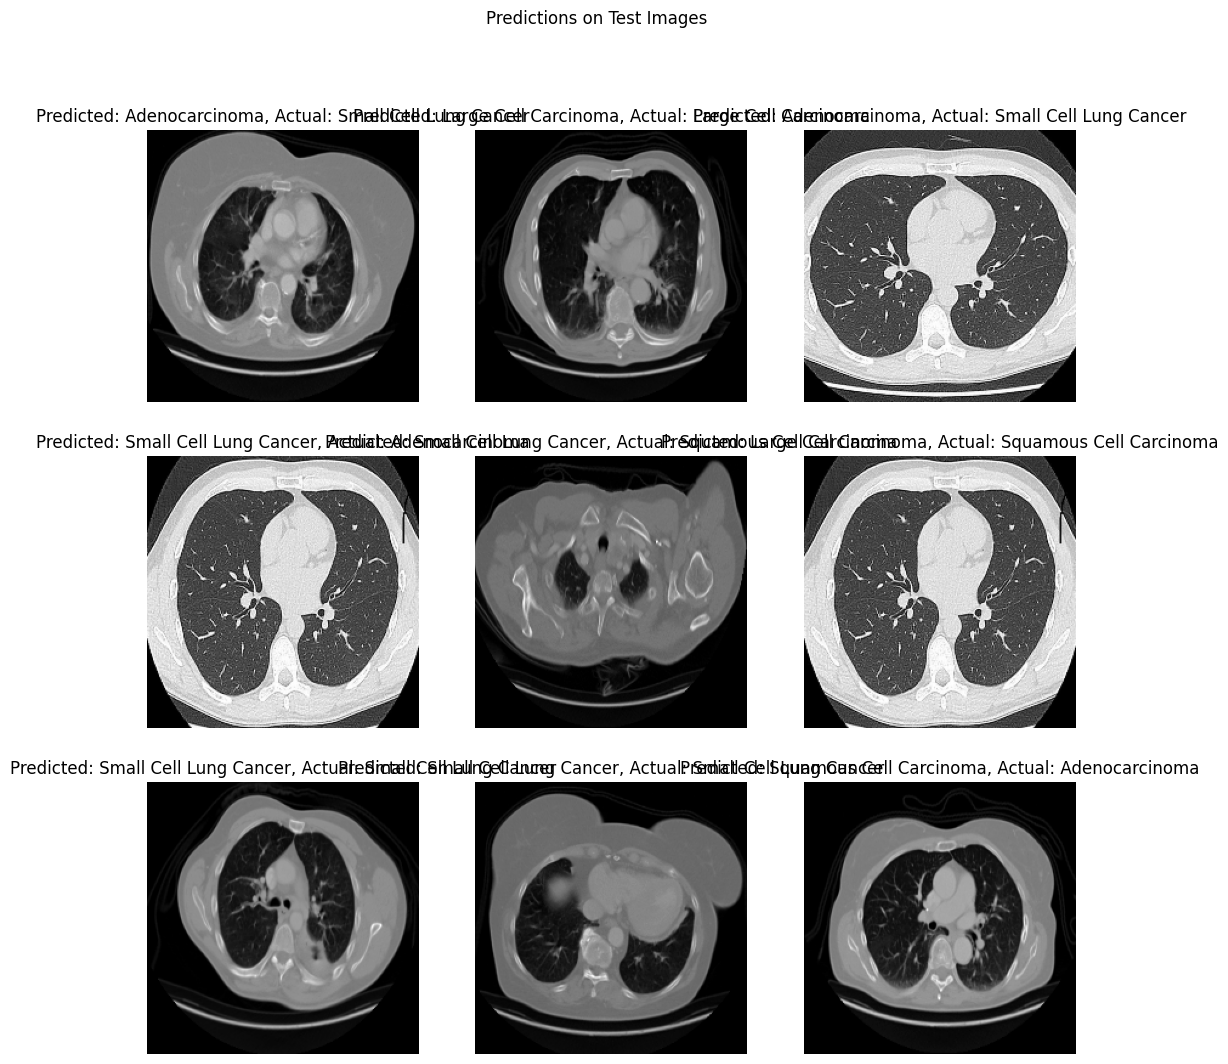

In [14]:
# Assuming you have already defined class_names earlier in your code
# If not, you can define it like this:
# class_names = train_generator.class_names  # This should already be defined in your previous code

# Define class names for lung cancer types
class_names = ['Adenocarcinoma', 'Squamous Cell Carcinoma', 'Large Cell Carcinoma', 'Small Cell Lung Cancer']

# Model Evaluation
# 1. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 3. ROC Curve
fpr = {}
tpr = {}
roc_auc = {}
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(N_CLASSES):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], class_names[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Displaying some predictions
plt.figure(figsize=(12, 12))
for images, labels in test_generator.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(f'Predicted: {class_names[y_pred_classes[i]]}, Actual: {class_names[y_true[i]]}')
        plt.axis('off')
plt.suptitle('Predictions on Test Images')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


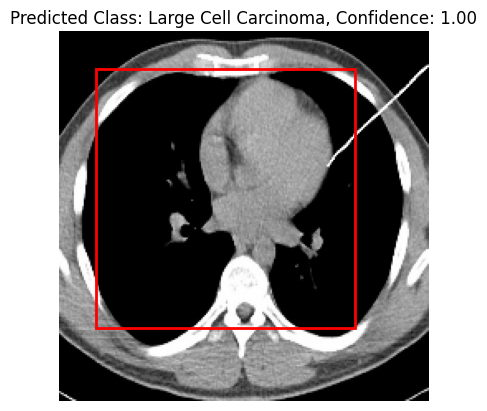

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


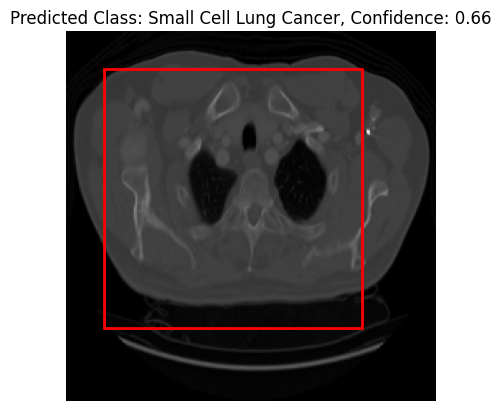

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


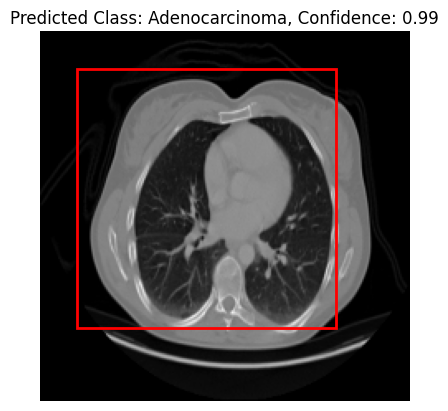

In [15]:
# Image Detection with ResNet50
def simulate_detection(image):
    height, width = image.shape[0:2]
    # Simulate a bounding box around the center of the image
    box = [0.1 * width, 0.1 * height, 0.8 * width, 0.8 * height]  # [x1, y1, x2, y2]
    confidence = np.random.rand()  # Random confidence score
    return box, confidence

# Display detection results using ResNet50 predictions
def display_detection_results(generator, model, num_images=3):
    for images_batch, _ in generator.take(1):
        for i in range(num_images):
            # Get the image and predict its class
            image = images_batch[i].numpy().astype("uint8")
            image_tensor = tf.convert_to_tensor(image)  # Convert to TensorFlow tensor
            image_rgb = convert_to_rgb(image_tensor)  # Convert to RGB for display
            predictions = model.predict(image_rgb[np.newaxis, ...])
            predicted_class = np.argmax(predictions, axis=1)[0]
            confidence = np.max(predictions)  # Get the confidence of the prediction

            # Simulate detection
            box, _ = simulate_detection(image)

            # Display the image with the bounding box
            plt.imshow(image_rgb.numpy().astype("uint8"))  # Convert back to NumPy for display
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red', linewidth=2))
            plt.title(f'Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}')
            plt.axis('off')
            plt.show()

# Call the function to display detection results
display_detection_results(test_generator, model)

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMAGE_SIZE = 224  # Define the image size
N_CLASSES = 1  # For binary segmentation
BATCH_SIZE = 8

# Image Segmentation with ResNet50
def build_segmentation_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u6 = tf.keras.layers.UpSampling2D((2, 2))(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.UpSampling2D((2, 2))(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.UpSampling2D((2, 2))(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.UpSampling2D((2, 2))(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the segmentation model
segmentation_model = build_segmentation_model((IMAGE_SIZE, IMAGE_SIZE, 1))
segmentation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Simulated training data for segmentation (replace with actual data)
# Assuming binary segmentation for simplicity
train_images = np.random.rand(100, IMAGE_SIZE, IMAGE_SIZE, 1)  # 100 random images
train_masks = np.random.randint(0, 2, (100, IMAGE_SIZE, IMAGE_SIZE, 1))  # Random binary masks

# Train the segmentation model
segmentation_history = segmentation_model.fit(train_images, train_masks, epochs=25, batch_size=BATCH_SIZE)

# Prepare test data (you should replace this with your actual test data)
# For demonstration, we will create random test images
test_images = np.random.rand(10, IMAGE_SIZE, IMAGE_SIZE, 1)  # 10 random test images

# Display segmentation results
for test_image in test_images:  # Iterate through the test images
    test_image = test_image.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)  # Ensure the shape is correct
    predicted_mask = segmentation_model.predict(test_image[np.newaxis, ...])  # Add batch dimension

    plt.subplot(1, 2, 1)
    plt.imshow(test_image.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.